# Costcla classifiers

In this notebook we compare the compare the performance of some of the cost-sensitve methods from the [Costcla package](http://albahnsen.com/CostSensitiveClassification/index.html) with some standard Scikit-learn classifiers on the [paysim dataset](https://www.kaggle.com/ntnu-testimon/paysim1).

## Preprocessing the data

First we perform some preprocessing tasks on the dataset such as importing it, removing unnecessary entries, and forming the training and test sets.

In [1]:
# Import packages we'll need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Read in the data
paysim_data = pd.read_csv("PS_20174392719_1491204439457_log.csv")

# Drop columns that do not aid in classification
paysim_data.drop(['step','nameOrig','nameDest'],axis=1,inplace=True)

df = paysim_data.loc[np.logical_or((paysim_data['type']=='CASH_OUT').values, (paysim_data['type']=='TRANSFER').values),:]
df = df.reset_index(drop=True,inplace=False)

# Convert the categorical variables TRANSFER and CASH_OUT to binary ones
from statsmodels.tools import categorical
types = np.array(df['type'])
cat = categorical(types,drop=True)
df['transfer'] = cat.argmax(1)  # 1 if TRANSFER, 0 if CASH_OUT
df['cash_out'] = cat.argmin(1)  # 0 if TRANSFER, 1 if CASH_OUT
df.drop(['type'],axis=1,inplace=True)
df.reset_index(drop=True,inplace=True)

# Split into target and features
X_full = df.ix[:, df.columns != 'isFraud']
Y_full = df.ix[:, df.columns =='isFraud']

# Drop transactions of amount 0
Y_full = Y_full[X_full['amount']!=0]
X_full = X_full[X_full['amount']!=0]
X_full.reset_index(drop=True,inplace=True)
Y_full.reset_index(drop=True,inplace=True)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_full ,Y_full, test_size=0.33, random_state=64)

# Then we figure out how many fraudulent cases we have in the training set
fraud_inds = np.array(y_train[y_train.isFraud==1].index)
normal_inds = np.array(y_train[y_train.isFraud==0].index)

X_train_fraud = X_train.ix[fraud_inds].reset_index(drop=True,inplace=False)
y_train_fraud = y_train.ix[fraud_inds].reset_index(drop=True,inplace=False)
X_test_fraud = X_test.ix[fraud_inds].reset_index(drop=True,inplace=False)
y_test_fraud = y_test.ix[fraud_inds].reset_index(drop=True,inplace=False)

X_train_normal = X_train.ix[normal_inds].reset_index(drop=True,inplace=False)
y_train_normal = y_train.ix[normal_inds].reset_index(drop=True,inplace=False)
X_test_normal = X_test.ix[normal_inds].reset_index(drop=True,inplace=False)
y_test_normal = y_test.ix[normal_inds].reset_index(drop=True,inplace=False)

# Partition up the training data into groups having an equal ratio of fraudulent and legitimate transactions
nFraud = len(fraud_inds)       # Number of fraudulent transactions
nLeg = len(normal_inds)        # Number of legitimate transactions
nSplits = nLeg / nFraud + 1    # Number of chunks data is broken into

In [2]:
# Define some functions that will be useful
# Append fraudulent transactions to normal ones specified by inds
def append_fraud(X_fraud,X_normal,y_fraud,y_normal,inds):
    return np.concatenate((X_fraud.values,X_normal.ix[inds].values)), np.concatenate((y_fraud.values,y_normal.ix[inds].values)).ravel()

# Get accuracy, recall, precision, and f1 scores
def get_scores(y_test,y_pred):
    return accuracy_score(y_test,y_pred), recall_score(y_test,y_pred), precision_score(y_test,y_pred), f1_score(y_test,y_pred)

# Get cost matrix associated with a set of transactions
def get_cost_mat(transactions,overhead):
    # cost_mat[i] = [cost_FP, cost_FN, cost_TP, cost_TN]_i    
    N = len(transactions)
    # Code for old cost function
    return np.stack([np.multiply(transactions>overhead, overhead), transactions,np.multiply(transactions>overhead,overhead)+np.multiply(transactions<=overhead,transactions) , np.zeros(N)],axis=1)

    

# Define one random 50/50 split set for initial tests
np.random.seed(11)
inds = np.random.choice(X_train_normal.shape[0],nFraud)
X_train_small, y_train_small = append_fraud(X_train_fraud,X_train_normal,y_train_fraud,y_train_normal,inds)

In [3]:
# Get cost matrices for small training set and overall training and test sets\
overhead = 1.e5
cost_mat_train_small = get_cost_mat(X_train_small[:,0],overhead)
cost_mat_train = get_cost_mat(X_train['amount'].values,overhead)
cost_mat_test = get_cost_mat(X_test['amount'].values,overhead)

Next we load some basic classifiers, train them on the small (undersampled) training set and evaluate them on the full test set.

In [4]:
# Sklearn classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
from costcla.metrics import savings_score

# To time the fitting process
import time

# Make a dictionary of basic classifiers where we can also store outputs
classifiers = {"RFu" : {"f": RandomForestClassifier()},
               "DTu" : {"f": DecisionTreeClassifier()},
               "GBu" : {"f": GradientBoostingClassifier()},
               "LRu" : {"f": LogisticRegression()},
               "RF" : {"f": RandomForestClassifier()},
               "DT" : {"f": DecisionTreeClassifier()},
               "GB" : {"f": GradientBoostingClassifier()},
               "LR" : {"f": LogisticRegression()}
              }

# Fit the classifiers and make predictions
base_models = ["RF", "DT", "GB", "LR"]
for model in base_models:
    # Fit the subsampled models
    t0 = time.time()
    classifiers[model + "u"]["f"].fit(X_train_small,y_train_small)
    tu = time.time() - t0

    # Make predictions with each
    classifiers[model + "u"]["p"] = classifiers[model + "u"]["f"].predict(X_test)

    # Fit the full models and predict with them
    t0 = time.time()
    classifiers[model]["f"].fit(X_train,y_train.values.ravel())
    tf = time.time() - t0
    classifiers[model]["p"] = classifiers[model]["f"].predict(X_test)
    print "The full %s model took %f times longer to train (%f seconds)." %(model, tf / tu, tf)
    
# Compute metrics for these classications
metrics = {"rec": recall_score, "acc": accuracy_score, "f1": f1_score, "prec": precision_score}
results = pd.DataFrame(columns=metrics.keys())

# Compute metrics for each classifier on test set
for model in classifiers.keys():
    results.loc[model] = [metrics[metric](y_test.values.ravel(),classifiers[model]["p"]) for metric in metrics.keys()]

# Compute savings for each classifier
results["sav"] = np.zeros(results.shape[0])
for model in classifiers.keys():
    results["sav"].loc[model] = savings_score(y_test.values.ravel(), classifiers[model]["p"], cost_mat_test)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The full RF model took 406.315631 times longer to train (48.346215 seconds).
The full DT model took 452.072080 times longer to train (16.436490 seconds).
The full GB model took 452.243593 times longer to train (306.247213 seconds).
The full LR model took 161.184947 times longer to train (14.546329 seconds).


In [5]:
# Function for creating bar charts more easily
def plot_bar_chart(base_models, results):
    n = len(base_models)
    k = results.shape[0] / n
    bar_width = 0.8 / k
    y_pos = np.arange(n)
    test_str = ["u", "", "u-BMR", "-BMR", "-meta"]
    labels = ["Undersampled", "Fully sampled", "Undersampled BMR", "Fully sampled BMR", "Meta learners"]

    plt.figure(figsize=(5*n,6))
    for i in xrange(k):
        cur_labels = [bm + test_str[i] for bm in base_models]
        plt.bar(y_pos + i*bar_width, results.loc[cur_labels]["sav"].values,bar_width,alpha=0.75,label=labels[i])

    plt.ylabel('Savings score')
    plt.title('Savings scores')
    plt.xticks(y_pos + (k-1) * bar_width / 2., base_models)
    plt.legend()
    plt.show()

In [6]:
# Import predictions from Neural nets
y_nnu = pd.read_csv('pred_by_subsample.csv',index_col=0).values.astype(int)
y_nn = pd.read_csv('pred_all.csv',index_col=0).values.astype(int)

In [7]:
# Compute metrics for NN predictions
nn_results = pd.DataFrame(columns=metrics.keys())
nn_results.loc["NNu"] = [metrics[metric](y_test.values.ravel(),y_nnu) for metric in metrics.keys()]
nn_results.loc["NN"] = [metrics[metric](y_test.values.ravel(),y_nn) for metric in metrics.keys()]

nn_results["sav"] = np.zeros(nn_results.shape[0])
nn_results["sav"].loc["NNu"] = savings_score(y_test.values.ravel(), y_nnu, cost_mat_test)
nn_results["sav"].loc["NN"] = savings_score(y_test.values.ravel(), y_nn, cost_mat_test)

          acc       rec      prec        f1       sav
RF   0.999247  0.766604  0.968706  0.855886  0.924994
GBu  0.973349  0.996998  0.098356  0.179049  0.587367
LRu  0.884548  0.956098  0.023597  0.046057 -0.218329
GB   0.997644  0.196623  0.975791  0.327295  0.409735
RFu  0.984290  0.987242  0.155130  0.268127  0.750293
LR   0.997366  0.732083  0.535254  0.618384  0.738093
DT   0.999392  0.896060  0.895388  0.895724  0.930912
DTu  0.987421  0.987617  0.186680  0.314006  0.796972
NNu  0.961819  0.953096  0.068058  0.127044  0.369042
NN   0.998650  0.562852  0.956023  0.708550  0.785971


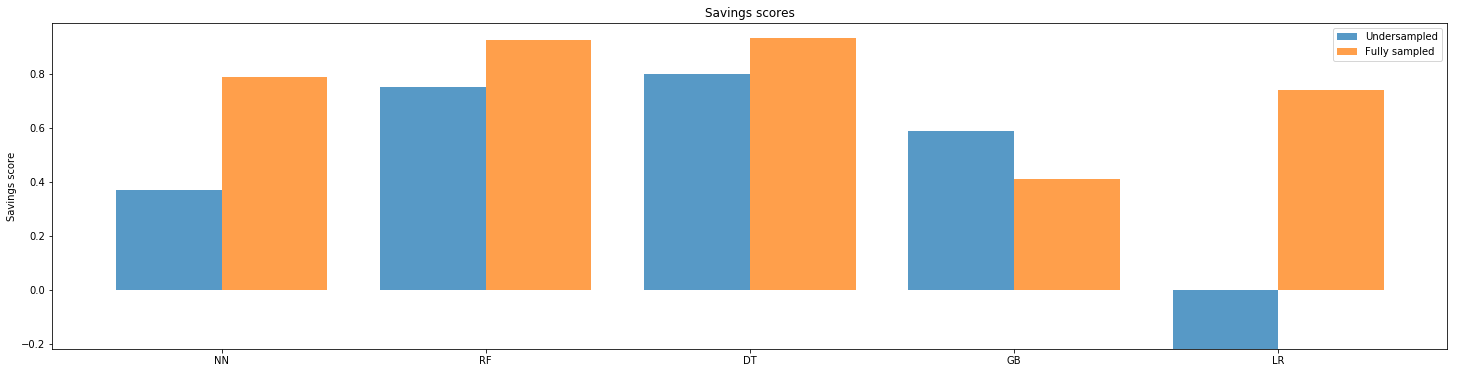

In [8]:
print results.append(nn_results)
base_models_ext = ['NN']
base_models_ext.extend(base_models)
plot_bar_chart(base_models_ext, results.append(nn_results))

## Cost sensitive classifiers

First we try modifying the classifiers above using Costcla's Bayes Minimum Risk Classifier. See [this](http://albahnsen.com/files/%20Improving%20Credit%20Card%20Fraud%20Detection%20by%20using%20Calibrated%20Probabilities%20-%20Publish.pdf) paper for information on how it's done.

In [9]:
# Costcla classifiers
from costcla.models import BayesMinimumRiskClassifier

# Augment the existing models using BMR
for model in base_models:

    classifiers[model + "u-BMR"] = {"f": BayesMinimumRiskClassifier()}
    classifiers[model + "-BMR"] = {"f": BayesMinimumRiskClassifier()}
    # We need the probabilities for each classification to use the BMR classifier
    classifiers[model + "u"]["prob"] = classifiers[model + "u"]["f"].predict_proba(X_test)
    classifiers[model]["prob"] = classifiers[model]["f"].predict_proba(X_test)
    
    # Now we can fit it
    classifiers[model + "u-BMR"]["f"].fit(y_test.values.ravel(), classifiers[model + "u"]["prob"])
    classifiers[model + "-BMR"]["f"].fit(y_test.values.ravel(), classifiers[model]["prob"])
    
    # Get predictions on the test set
    classifiers[model + "u-BMR"]["p"] = classifiers[model + "u-BMR"]["f"].predict(classifiers[model + "u"]["prob"],cost_mat_test)
    classifiers[model + "-BMR"]["p"] = classifiers[model + "-BMR"]["f"].predict(classifiers[model]["prob"],cost_mat_test)
    
    # Compute metrics
    results.loc[model + "u-BMR"] = 0
    results.loc[model + "-BMR"] = 0
    for metric in metrics.keys():
        results.loc[model + "u-BMR", metric] = metrics[metric](y_test.values.ravel(), classifiers[model + "u-BMR"]["p"])
        results.loc[model + "-BMR", metric] = metrics[metric](y_test.values.ravel(), classifiers[model + "-BMR"]["p"])
    results["sav"].loc[model + "u-BMR"] = savings_score(y_test.values.ravel(),classifiers[model + "u-BMR"]["p"], cost_mat_test)
    results["sav"].loc[model + "-BMR"] = savings_score(y_test.values.ravel(),classifiers[model + "-BMR"]["p"], cost_mat_test)


/usr/local/lib/python2.7/dist-packages/costcla/models/directcost.py:101: RuntimeWarning: invalid value encountered in divide
  t_bmr = (cost_mat[:, 0] - cost_mat[:, 3]) / (cost_mat[:, 1] - cost_mat[:, 3] - cost_mat[:, 2] + cost_mat[:, 0])
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/usr/local/lib/python2.7/dist-packages/costcla/models/directcost.py:103: RuntimeWarning: invalid value encountered in greater
  y_pred = np.greater(y_prob[:, 1], t_bmr).astype(np.float)


In [10]:

# Do the same thing for the neural nets
classifiers["NNu-BMR"] = {"f": BayesMinimumRiskClassifier()}
classifiers["NN-BMR"] = {"f": BayesMinimumRiskClassifier()}
prob_nnu = pd.read_csv('prob_pred_by_subsample.csv',index_col=0).values
prob_nn = pd.read_csv('prob_pred_all.csv',index_col=0).values

# Fit the BRM models
classifiers["NNu-BMR"]["f"].fit(y_test.values.ravel(), prob_nnu)
classifiers["NN-BMR"]["f"].fit(y_test.values.ravel(), prob_nn)

# Predict on test set
classifiers["NNu-BMR"]["p"] = classifiers["NNu-BMR"]["f"].predict(prob_nnu,cost_mat_test)
classifiers["NN-BMR"]["p"] = classifiers["NN-BMR"]["f"].predict(prob_nn,cost_mat_test)

# Get metrics
nn_results.loc["NNu-BMR"] = 0
nn_results.loc["NN-BMR"] = 0
for metric in metrics.keys():
    nn_results.loc["NNu-BMR",metric] = metrics[metric](y_test.values.ravel(), classifiers["NNu-BMR"]["p"])
    nn_results.loc["NN-BMR",metric] = metrics[metric](y_test.values.ravel(), classifiers["NN-BMR"]["p"])
nn_results["sav"].loc["NNu-BMR"] = savings_score(y_test.values.ravel(),classifiers["NNu-BMR"]["p"], cost_mat_test)
nn_results["sav"].loc["NN-BMR"] = savings_score(y_test.values.ravel(),classifiers["NN-BMR"]["p"], cost_mat_test)


print results.append(nn_results)

              acc       rec      prec        f1       sav
RF       0.999247  0.766604  0.968706  0.855886  0.924994
GBu      0.973349  0.996998  0.098356  0.179049  0.587367
LRu      0.884548  0.956098  0.023597  0.046057 -0.218329
GB       0.997644  0.196623  0.975791  0.327295  0.409735
RFu      0.984290  0.987242  0.155130  0.268127  0.750293
LR       0.997366  0.732083  0.535254  0.618384  0.738093
DT       0.999392  0.896060  0.895388  0.895724  0.930912
DTu      0.987421  0.987617  0.186680  0.314006  0.796972
RFu-BMR  0.998171  0.631520  0.709229  0.668122  0.910749
RF-BMR   0.998878  0.676173  0.917048  0.778402  0.928169
DTu-BMR  0.997568  0.454409  0.611616  0.521421  0.884803
DT-BMR   0.999018  0.719700  0.927018  0.810308  0.931359
GBu-BMR  0.997941  0.599625  0.662246  0.629382  0.906683
GB-BMR   0.997303  0.241651  0.591368  0.343101  0.411505
LRu-BMR  0.998040  0.461538  0.775047  0.578551  0.882723
LR-BMR   0.998373  0.517824  0.872314  0.649870  0.748716
NNu      0.961

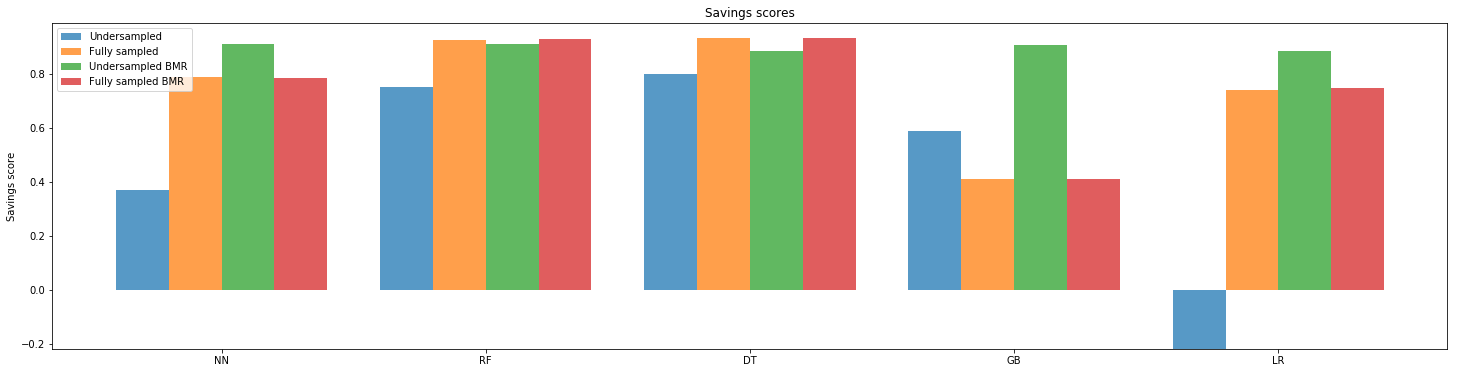

In [11]:
# Plot the savings
plot_bar_chart(base_models_ext, results.append(nn_results))

## Meta-learners

It has come to my attention that these ensembles are very similar to the EasyEnsemble models of [this](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4717268) paper.

In [12]:
nSamples = 25     # Number of 50/50 splits (and classifiers) to use

samples = np.random.choice(range(nSplits-1),nSamples,replace=False)
inds_subsamp = [range(k*nFraud,(k+1)*nFraud) for k in samples]


for model in base_models:

    if model == "RF":
        # All random forests
        sub_classifiers = [RandomForestClassifier() for k in xrange(nSamples)]
    elif model == "DT":
        # All Decision trees
        sub_classifiers = [DecisionTreeClassifier() for k in xrange(nSamples)]
    elif model == "GB":
        # All gradient boost
        sub_classifiers = [GradientBoostingClassifier() for k in xrange(nSamples)]
    else:
        # All Logistic regression
        sub_classifiers = [LogisticRegression() for k in xrange(nSamples)]




    y_pred = np.zeros(X_test.shape[0])
    # y_prob = np.zeros((X_test.shape[0],2))

    for k in range(nSamples):
        # Fit the model
        sub_classifiers[k].fit(*append_fraud(X_train_fraud,X_train_normal,y_train_fraud,y_train_normal,inds_subsamp[k]))

        # Keep running total of predictions on the test set (to be averaged at the end)
        temp_pred = sub_classifiers[k].predict(X_test)
        y_pred += temp_pred
        # y_prob += sub_classifiers[k].predict_proba(X_test)


    # Average predictions
    y_pred /= float(nSamples)

    # Map to 0 if less than 0.5, 1 otherwise
    y_pred[y_pred < 0.5] = 0.
    y_pred[y_pred >= 0.5] = 1.

    # y_pred_prob = np.argmax(y_prob,axis=1)

    # Check metrics for meta-learner
    for metric in metrics.keys():
        results.loc[model + "-meta", metric] = metrics[metric](y_test.values.ravel(), y_pred)
    results["sav"].loc[model + "-meta"] = savings_score(y_test.values.ravel(),y_pred, cost_mat_test)

print results

              acc       rec      prec        f1       sav
RF       0.999247  0.766604  0.968706  0.855886  0.924994
GBu      0.973349  0.996998  0.098356  0.179049  0.587367
LRu      0.884548  0.956098  0.023597  0.046057 -0.218329
GB       0.997644  0.196623  0.975791  0.327295  0.409735
RFu      0.984290  0.987242  0.155130  0.268127  0.750293
LR       0.997366  0.732083  0.535254  0.618384  0.738093
DT       0.999392  0.896060  0.895388  0.895724  0.930912
DTu      0.987421  0.987617  0.186680  0.314006  0.796972
RFu-BMR  0.998171  0.631520  0.709229  0.668122  0.910749
RF-BMR   0.998878  0.676173  0.917048  0.778402  0.928169
DTu-BMR  0.997568  0.454409  0.611616  0.521421  0.884803
DT-BMR   0.999018  0.719700  0.927018  0.810308  0.931359
GBu-BMR  0.997941  0.599625  0.662246  0.629382  0.906683
GB-BMR   0.997303  0.241651  0.591368  0.343101  0.411505
LRu-BMR  0.998040  0.461538  0.775047  0.578551  0.882723
LR-BMR   0.998373  0.517824  0.872314  0.649870  0.748716
RF-meta  0.984

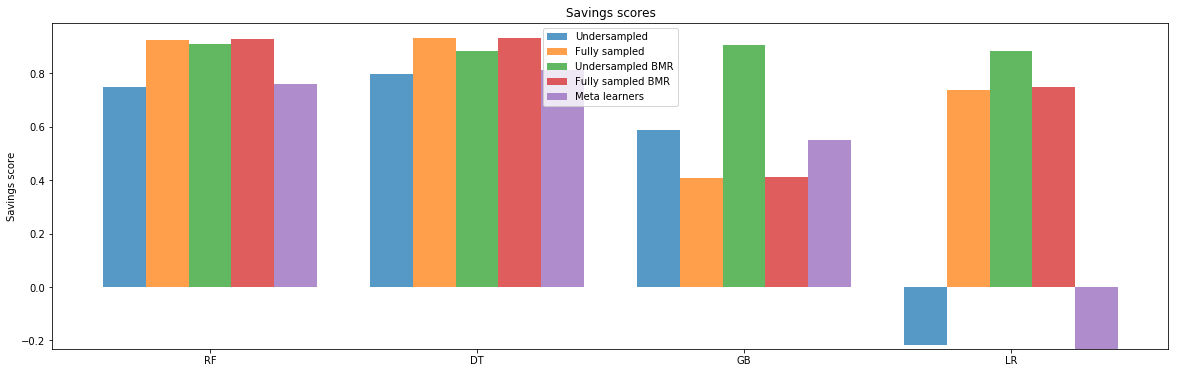

In [13]:
# Plot the savings
plot_bar_chart(base_models, results)

## Cost sensitive decision trees

In [14]:
from costcla.models import CostSensitiveDecisionTreeClassifier

# Train one cost-sensitve decision tree on the undersampled training set
classifiers["CSDTu"] = {"f": CostSensitiveDecisionTreeClassifier()}

# Fit it directly with the data (note it's not built on top of a decision tree)
classifiers["CSDTu"]["f"].fit(X_train_small,y_train_small,cost_mat_train_small)

# Predict on the test set
classifiers["CSDTu"]["p"] = classifiers["CSDTu"]["f"].predict(X_test.values)

# Get metrics
results.loc["CSDTu"] = 0
for metric in metrics.keys():
    results.loc["CSDTu", metric] = metrics[metric](y_test.values.ravel(), classifiers["CSDTu"]["p"])
results["sav"].loc["CSDTu"] = savings_score(y_test.values.ravel(),classifiers["CSDTu"]["p"], cost_mat_test)

# Train another on the full training set
classifiers["CSDT"] = {"f": CostSensitiveDecisionTreeClassifier()}

classifiers["CSDT"]["f"].fit(X_train.values,y_train.values,cost_mat_train)

# Predict on the test set
classifiers["CSDT"]["p"] = classifiers["CSDT"]["f"].predict(X_test.values)

# Get metrics
results.loc["CSDT"] = 0
for metric in metrics.keys():
    results.loc["CSDT", metric] = metrics[metric](y_test.values.ravel(), classifiers["CSDT"]["p"])
results["sav"].loc["CSDT"] = savings_score(y_test.values.ravel(),classifiers["CSDT"]["p"], cost_mat_test)

print results

              acc       rec      prec        f1       sav
RF       0.999247  0.766604  0.968706  0.855886  0.924994
GBu      0.973349  0.996998  0.098356  0.179049  0.587367
LRu      0.884548  0.956098  0.023597  0.046057 -0.218329
GB       0.997644  0.196623  0.975791  0.327295  0.409735
RFu      0.984290  0.987242  0.155130  0.268127  0.750293
LR       0.997366  0.732083  0.535254  0.618384  0.738093
DT       0.999392  0.896060  0.895388  0.895724  0.930912
DTu      0.987421  0.987617  0.186680  0.314006  0.796972
RFu-BMR  0.998171  0.631520  0.709229  0.668122  0.910749
RF-BMR   0.998878  0.676173  0.917048  0.778402  0.928169
DTu-BMR  0.997568  0.454409  0.611616  0.521421  0.884803
DT-BMR   0.999018  0.719700  0.927018  0.810308  0.931359
GBu-BMR  0.997941  0.599625  0.662246  0.629382  0.906683
GB-BMR   0.997303  0.241651  0.591368  0.343101  0.411505
LRu-BMR  0.998040  0.461538  0.775047  0.578551  0.882723
LR-BMR   0.998373  0.517824  0.872314  0.649870  0.748716
RF-meta  0.984

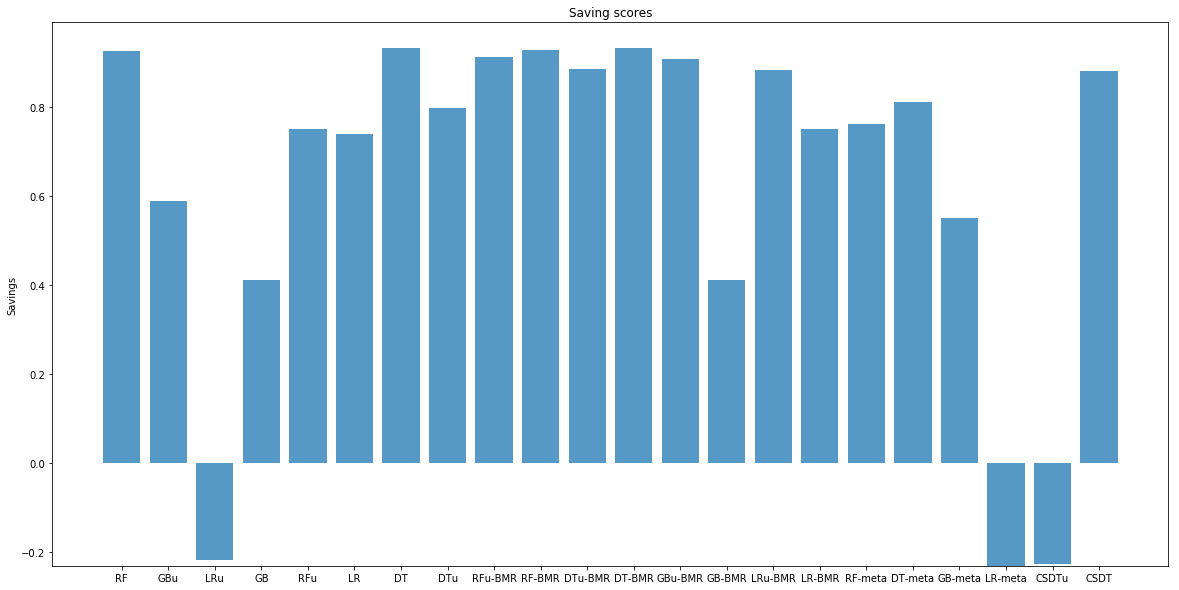

In [15]:
# Plot new savings bar chart
plt.figure(1, figsize=(20,10))
y_pos = range(results.shape[0])
plt.bar(y_pos,results['sav'].values,alpha=0.75)
plt.xticks(y_pos,results.index.values)
plt.ylabel('Savings')
plt.title('Saving scores')
plt.show()

## Cost sensitive Random Forest

In [16]:
from costcla.models import CostSensitiveRandomForestClassifier

# Train one cost-sensitve random forest on the undersampled training set
classifiers["CSRFu"] = {"f": CostSensitiveRandomForestClassifier()}

# Fit it directly with the data (note it's not built on top of a random forest)
classifiers["CSRFu"]["f"].fit(X_train_small,y_train_small,cost_mat_train_small)

# Predict on the test set
classifiers["CSRFu"]["p"] = classifiers["CSRFu"]["f"].predict(X_test.values)

# Get metrics
results.loc["CSRFu"] = 0
for metric in metrics.keys():
    results.loc["CSRFu", metric] = metrics[metric](y_test.values.ravel(), classifiers["CSRFu"]["p"])
results["sav"].loc["CSRFu"] = savings_score(y_test.values.ravel(),classifiers["CSRFu"]["p"], cost_mat_test)

# Train another on the full training set
classifiers["CSRF"] = {"f": CostSensitiveRandomForestClassifier()}

classifiers["CSRF"]["f"].fit(X_train.values,y_train.values,cost_mat_train)

# Predict on the test set
classifiers["CSRF"]["p"] = classifiers["CSRF"]["f"].predict(X_test.values)

# Get metrics
results.loc["CSRF"] = 0
for metric in metrics.keys():
    results.loc["CSRF", metric] = metrics[metric](y_test.values.ravel(), classifiers["CSRF"]["p"])
results["sav"].loc["CSRF"] = savings_score(y_test.values.ravel(),classifiers["CSRF"]["p"], cost_mat_test)

print results

/usr/local/lib/python2.7/dist-packages/costcla/models/bagging.py:485: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              acc       rec      prec        f1        sav
RF       0.999247  0.766604  0.968706  0.855886   0.924994
GBu      0.973349  0.996998  0.098356  0.179049   0.587367
LRu      0.884548  0.956098  0.023597  0.046057  -0.218329
GB       0.997644  0.196623  0.975791  0.327295   0.409735
RFu      0.984290  0.987242  0.155130  0.268127   0.750293
LR       0.997366  0.732083  0.535254  0.618384   0.738093
DT       0.999392  0.896060  0.895388  0.895724   0.930912
DTu      0.987421  0.987617  0.186680  0.314006   0.796972
RFu-BMR  0.998171  0.631520  0.709229  0.668122   0.910749
RF-BMR   0.998878  0.676173  0.917048  0.778402   0.928169
DTu-BMR  0.997568  0.454409  0.611616  0.521421   0.884803
DT-BMR   0.999018  0.719700  0.927018  0.810308   0.931359
GBu-BMR  0.997941  0.599625  0.662246  0.629382   0.906683
GB-BMR   0.997303  0.241651  0.591368  0.343101   0.411505
LRu-BMR  0.998040  0.461538  0.775047  0.578551   0.882723
LR-BMR   0.998373  0.517824  0.872314  0.649870   0.7487

## Cost Sensitive logistic regression

In [17]:
from costcla.models import CostSensitiveLogisticRegression

# Train one cost-sensitve random forest on the undersampled training set
classifiers["CSLRu"] = {"f": CostSensitiveLogisticRegression()}

# Fit it directly with the data (note it's not built on top of a random forest)
classifiers["CSLRu"]["f"].fit(X_train_small,y_train_small,cost_mat_train_small)

# Predict on the test set
classifiers["CSLRu"]["p"] = classifiers["CSLRu"]["f"].predict(X_test.values)

# Get metrics
results.loc["CSLRu"] = 0
for metric in metrics.keys():
    results.loc["CSLRu", metric] = metrics[metric](y_test.values.ravel(), classifiers["CSLRu"]["p"])
results["sav"].loc["CSLRu"] = savings_score(y_test.values.ravel(),classifiers["CSLRu"]["p"], cost_mat_test)

# Train another on the full training set
classifiers["CSLR"] = {"f": CostSensitiveLogisticRegression()}

classifiers["CSLR"]["f"].fit(X_train.values,y_train.values,cost_mat_train)

# Predict on the test set
classifiers["CSLR"]["p"] = classifiers["CSLR"]["f"].predict(X_test.values)

# Get metrics
results.loc["CSLR"] = 0
for metric in metrics.keys():
    results.loc["CSLR", metric] = metrics[metric](y_test.values.ravel(), classifiers["CSLR"]["p"])
results["sav"].loc["CSLR"] = savings_score(y_test.values.ravel(),classifiers["CSLR"]["p"], cost_mat_test)

print results

/usr/local/lib/python2.7/dist-packages/costcla/models/regression.py:45: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


              acc       rec      prec        f1        sav
RF       0.999247  0.766604  0.968706  0.855886   0.924994
GBu      0.973349  0.996998  0.098356  0.179049   0.587367
LRu      0.884548  0.956098  0.023597  0.046057  -0.218329
GB       0.997644  0.196623  0.975791  0.327295   0.409735
RFu      0.984290  0.987242  0.155130  0.268127   0.750293
LR       0.997366  0.732083  0.535254  0.618384   0.738093
DT       0.999392  0.896060  0.895388  0.895724   0.930912
DTu      0.987421  0.987617  0.186680  0.314006   0.796972
RFu-BMR  0.998171  0.631520  0.709229  0.668122   0.910749
RF-BMR   0.998878  0.676173  0.917048  0.778402   0.928169
DTu-BMR  0.997568  0.454409  0.611616  0.521421   0.884803
DT-BMR   0.999018  0.719700  0.927018  0.810308   0.931359
GBu-BMR  0.997941  0.599625  0.662246  0.629382   0.906683
GB-BMR   0.997303  0.241651  0.591368  0.343101   0.411505
LRu-BMR  0.998040  0.461538  0.775047  0.578551   0.882723
LR-BMR   0.998373  0.517824  0.872314  0.649870   0.7487

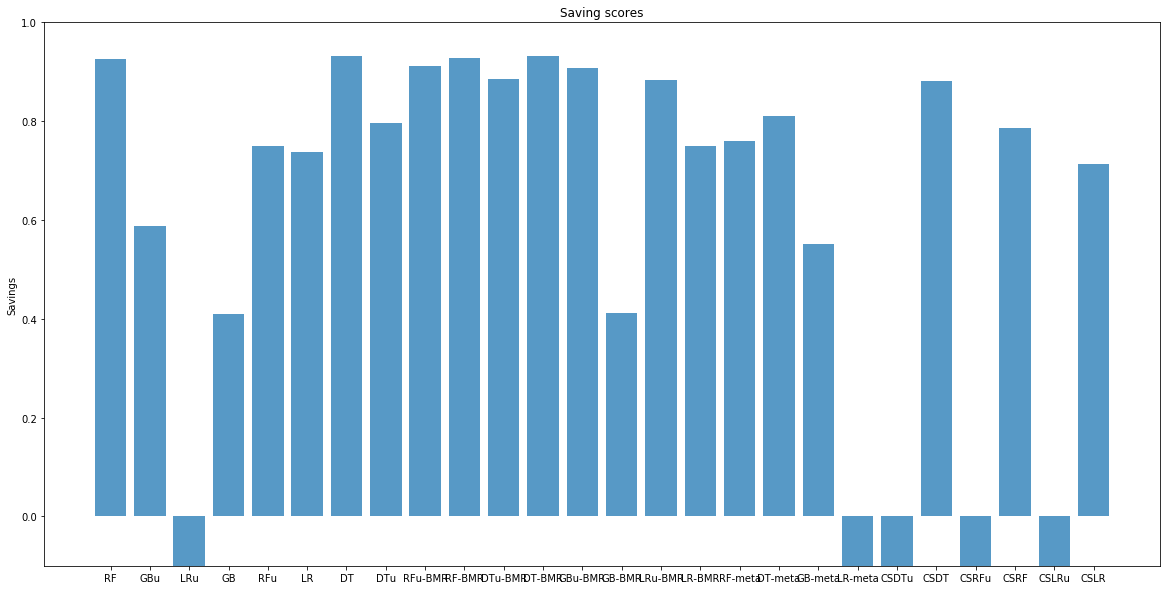

In [18]:
# Plot new savings bar chart
plt.figure(figsize=(20,10))
y_pos = range(results.shape[0])
plt.bar(y_pos,results['sav'].values,alpha=0.75)
plt.xticks(y_pos,results.index.values)
plt.ylabel('Savings')
plt.title('Saving scores')
plt.ylim((-0.1,1))
plt.show()

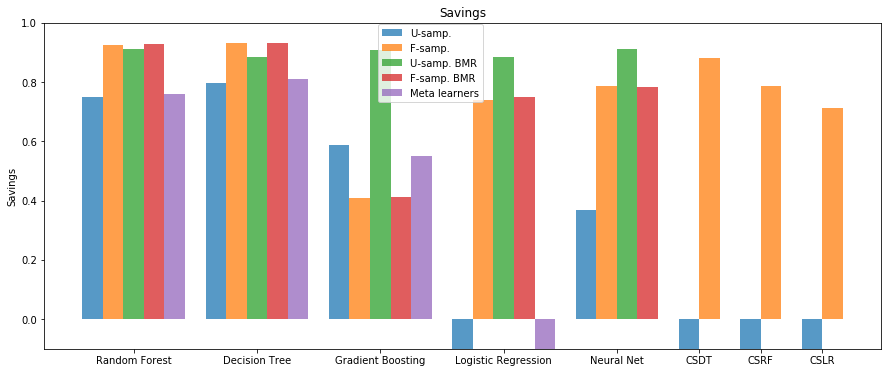

In [50]:
# Try to summarize everything with one plot

bw = 0.2
g = np.linspace(0,36*bw,37)
y_pos_u = np.array([g[0],g[6],g[12],g[18],g[24],g[29],g[32],g[35]])
y_pos_ci = np.array([g[0],g[6],g[12],g[18],g[24]])
all_names = ['RF','DT','GB','LR','NN','CSDT','CSRF','CSLR']
y_pos_meta = [g[4],g[10],g[16],g[22]]
x_ticks = [g[2],g[8],g[14],g[20],(g[25]+g[26])/2.,(g[29]+g[30])/2.,(g[32]+g[33])/2.,(g[35]+g[36])/2.]
primary_methods = ['RF','DT','GB','LR','NN']
all_results = results.append(nn_results)
labels = ["U-samp.", "F-samp.", "U-samp. BMR", "F-samp. BMR", "Meta learners"]

plt.figure(figsize=(15,6))
plt.bar(y_pos_u,all_results.loc[[name + 'u' for name in all_names]]["sav"].values,bw,alpha=0.75,label=labels[0])
plt.bar(y_pos_u + bw,all_results.loc[all_names]["sav"].values,bw,alpha=0.75,label=labels[1])
plt.bar(y_pos_ci + 2*bw,all_results.loc[[name + 'u-BMR' for name in primary_methods]]["sav"].values,bw,alpha=0.75,label=labels[2])
plt.bar(y_pos_ci + 3*bw,all_results.loc[[name + '-BMR' for name in primary_methods]]["sav"].values,bw,alpha=0.75,label=labels[3])
plt.bar(y_pos_meta, all_results.loc[[name + '-meta' for name in base_models]]["sav"].values,bw,alpha=0.75,label=labels[4])

full_names = ['Random Forest', 'Decision Tree', 'Gradient Boosting', 'Logistic Regression', 'Neural Net', 'CSDT', "CSRF", "CSLR"]
plt.xticks(x_ticks,full_names)
plt.ylabel('Savings')
plt.title('Savings')
plt.ylim((-0.1,1))
plt.legend(loc='upper right', bbox_to_anchor=(0.53,1.01))
plt.savefig('model_comparison.pdf')
plt.show()


# Old code from before we included logistic regression

# bw = 0.2
# g = np.linspace(0,27*bw,28)
# y_pos_u = np.array([g[0],g[6],g[12],g[18],g[23],g[26]])
# y_pos_ci = np.array([g[0],g[6],g[12],g[18]])
# all_names = ['RF','DT','GB','NN','CSDT','CSRF']
# y_pos_meta = [g[4],g[10],g[16]]
# x_ticks = [g[2],g[8],g[14],(g[19]+g[20])/2.,(g[24]+g[23])/2.,(g[27]+g[26])/2.]
# primary_methods = ['RF','DT','GB','NN']
# all_results = results.append(nn_results)
# labels = ["U-samp.", "F-samp.", "U-samp. BMR", "F-samp. BMR", "Meta learners"]

# plt.figure(figsize=(15,6))
# plt.bar(y_pos_u,all_results.loc[[name + 'u' for name in all_names]]["sav"].values,bw,alpha=0.75,label=labels[0])
# plt.bar(y_pos_u + bw,all_results.loc[all_names]["sav"].values,bw,alpha=0.75,label=labels[1])
# plt.bar(y_pos_ci + 2*bw,all_results.loc[[name + 'u-BMR' for name in primary_methods]]["sav"].values,bw,alpha=0.75,label=labels[2])
# plt.bar(y_pos_ci + 3*bw,all_results.loc[[name + '-BMR' for name in primary_methods]]["sav"].values,bw,alpha=0.75,label=labels[3])
# plt.bar(y_pos_meta, all_results.loc[[name + '-meta' for name in base_models]]["sav"].values,bw,alpha=0.75,label=labels[4])

# full_names = ['Random Forest', 'Decision Tree', 'Gradient Boosting', 'Neural Net', 'CSDT', "CSRF"]
# plt.xticks(x_ticks,full_names)
# plt.ylabel('Savings')
# plt.title('Savings')
# plt.ylim((-0.1,1))
# plt.legend(loc='upper right', bbox_to_anchor=(0.666,1))
# plt.savefig('model_comparison.pdf')
# plt.show()


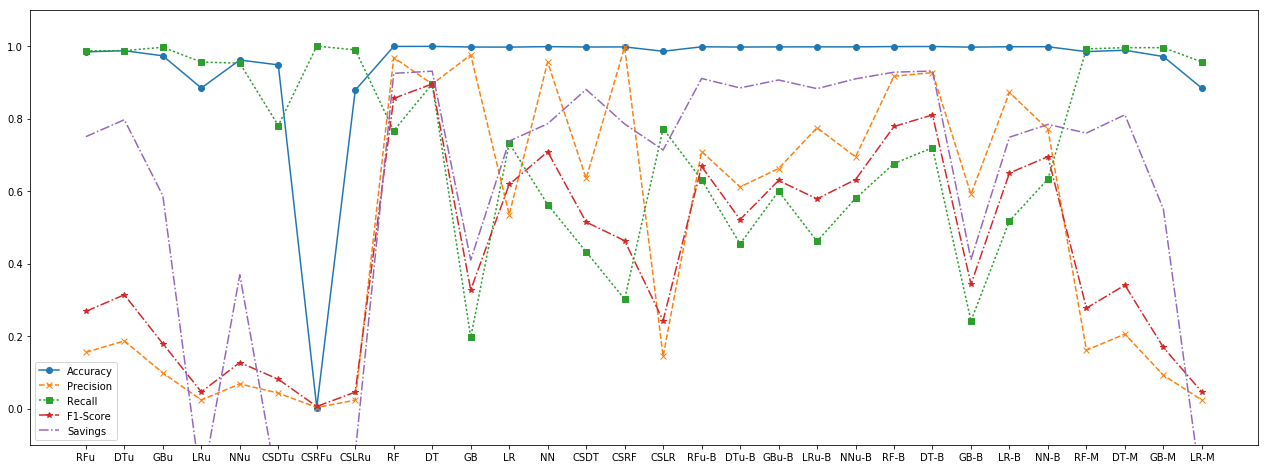

In [58]:
# Get new ordering for plotting results
new_inds = [name + 'u' for name in primary_methods]
new_inds.extend(['CSDTu','CSRFu','CSLRu'])
new_inds.extend(primary_methods)
new_inds.extend(['CSDT','CSRF','CSLR'])
new_inds.extend([name + 'u-BMR' for name in primary_methods])
new_inds.extend([name + '-BMR' for name in primary_methods])
new_inds.extend([name + '-meta' for name in base_models])

# Construct list with names to put along x-axis
x_ticks = [name + 'u' for name in primary_methods]
x_ticks.extend(['CSDTu','CSRFu','CSLRu'])
x_ticks.extend(primary_methods)
x_ticks.extend(['CSDT','CSRF','CSLR'])
x_ticks.extend([name + 'u-B' for name in primary_methods])
x_ticks.extend([name + '-B' for name in primary_methods])
x_ticks.extend([name + '-M' for name in base_models])

all_results = all_results.reindex(new_inds)
# print all_results
plt.figure(figsize=(22,8))
plt.plot(all_results["acc"].values,'-o',label='Accuracy')
plt.plot(all_results["prec"].values,'--x',label='Precision')
plt.plot(all_results["rec"].values,':s',label='Recall')
plt.plot(all_results["f1"].values,'-.*',label='F1-Score')
# plt.plot(all_results["sav"].values,'-.',label='Savings')
plt.ylim((-0.1,1.1))


plt.xticks(range(len(all_results)), x_ticks)
plt.legend()
plt.savefig('model_metrics.pdf')
plt.show()

# Old code before we added logistic regression

# new_inds = [name + 'u' for name in primary_methods]
# new_inds.extend(['CSDTu','CSRFu'])
# new_inds.extend(primary_methods)
# new_inds.extend(['CSDT','CSRF'])
# new_inds.extend([name + 'u-BMR' for name in primary_methods])
# new_inds.extend([name + '-BMR' for name in primary_methods])
# new_inds.extend([name + '-meta' for name in base_models])

# all_results = all_results.reindex(new_inds)
# plt.figure(figsize=(22,5))
# plt.plot(all_results["acc"].values,'-o',label='Accuracy')
# plt.plot(all_results["prec"].values,'--x',label='Precision')
# plt.plot(all_results["rec"].values,':s',label='Recall')
# plt.plot(all_results["f1"].values,'-.*',label='F1-Score')


# plt.xticks(range(len(all_results)), all_results.index.values)
# plt.legend()
# plt.savefig('model_metrics.pdf')
# plt.show()


In [62]:
print all_results.append(nn_results)

              acc       rec      prec        f1        sav
RFu      0.984290  0.987242  0.155130  0.268127   0.750293
DTu      0.987421  0.987617  0.186680  0.314006   0.796972
GBu      0.973349  0.996998  0.098356  0.179049   0.587367
LRu      0.884548  0.956098  0.023597  0.046057  -0.218329
NNu      0.961819  0.953096  0.068058  0.127044   0.369042
CSDTu    0.948285  0.780863  0.042664  0.080908  -0.228109
CSRFu    0.002915  1.000000  0.002915  0.005813 -15.024436
CSLRu    0.878556  0.989869  0.023214  0.045364  -0.123041
RF       0.999247  0.766604  0.968706  0.855886   0.924994
DT       0.999392  0.896060  0.895388  0.895724   0.930912
GB       0.997644  0.196623  0.975791  0.327295   0.409735
LR       0.997366  0.732083  0.535254  0.618384   0.738093
NN       0.998650  0.562852  0.956023  0.708550   0.785971
CSDT     0.997621  0.432645  0.634912  0.514617   0.880572
CSRF     0.997962  0.301689  0.997519  0.463267   0.785313
CSLR     0.985964  0.772608  0.144137  0.242950   0.7134